<a href="https://colab.research.google.com/github/CarlViggo/Carl-Viggo---Rays-2023/blob/main/Rays%2C_DL_Project%2C_Carl_Viggo_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Pipeline
The following code classifies images of lung tumors from the Kaggle Data Science Bowl 2017 data set. The datasets are initially balanced using a General Adversarial Neural Network. 

**Part 1** \\
Random Forests, Decision Tree and K-Nearest Neighbors are initially compared to one another. The best model is chosen and evaluated furter. The code for Part 1 is in-house software and therefore not publically availible. 

**Part 2** \\
Dataset is balanced using GAN technology. A pretrained InceptionV3 and a VGG16 are fine-tuned and evaluated. 

Contributor: Carl Viggo Nilsson Gravenhorst-Lövenstierne. carlviggo@icloud.com

**The following definitions are used in the code**
\
\
1 - Malignant \\
0 - Benign
\
\
Class1 - benign \\
Class2 - malignant
\
\
Train size = 907 \\
Validation size = 390

---

In [2]:
pip install scikit-image



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import os
import cv2
import numpy as np
from random import shuffle
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.transform import resize
import pickle

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout, ZeroPadding2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Convolution2D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from tensorflow.keras import applications
from keras.layers import GlobalAveragePooling2D


In [9]:
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

Functions to combine data with labels

In [10]:
#Matches the file name with its corresponding class
def gen_labels(im_name, data_path, pat1, pat2):
    '''

    Parameters
    ----------
    im_name : Str
        The image file name.

    Returns
    -------
    Label : Numpy array
        Class label of the filename name based on its pattern.
    '''
    if "C1" in data_path:
        label = np.array([0])
    elif "C2" or "Malignant" in data_path:
        label = np.array([1])
    return label

#Creates a nested list with the following structure: [(file_name, label), ...]
def get_data(data_path, data_list, img_h, img_w):
    """

    Parameters
    ----------
    train_data_path : Str
        Path to the data directory
    train_list : List
        A list containing the name of the images.
    img_h : Int
        image height to be resized to.
    img_w : Int
        image width to be resized to.
    """
    img_labels = []
    for item in enumerate(data_list):
        img = imread(os.path.join(data_path, item[1]), as_gray = False) # "as_grey"
        #img = cv2.imread(os.path.join(data_path, item[1]))
        img = resize(img, (img_h, img_w), anti_aliasing = True).astype('float32')
        img_labels.append([np.array(img), gen_labels(item[1], data_path,  'AFF', 'NFF')])

        if item[0] % 100 == 0:
             print('Reading: {0}/{1}  of train images'.format(item[0], len(data_list)))

    #Shuffles the list for generalization purposes
    shuffle(img_labels)
    return img_labels

#Unfolds the images and converts them to compatible arrays.
def get_data_arrays(nested_list, img_h, img_w):
    """
    Parameters
    ----------
    nested_list : nested list
        nested list of image arrays with corresponding class labels.
    img_h : Int
        Image height.
    img_w : Int
        Image width.

    Returns
    -------
    img_arrays : Numpy array
        4D Array with the size of (n_data,img_h,img_w, 1)
    label_arrays : Numpy array
        1D array with the size (n_data).

    """
    img_arrays = np.zeros((len(nested_list), img_h, img_w), dtype = np.float32)
    label_arrays = np.zeros((len(nested_list)), dtype = np.int32)
    for ind in range(len(nested_list)):
        img_arrays[ind] = nested_list[ind][0]
        label_arrays[ind] = nested_list[ind][1]
    img_arrays = np.expand_dims(img_arrays, axis =3)
    return img_arrays, label_arrays

#Returns the training and the testing data
def get_train_test_arrays(train_data_path, test_data_path, train_list,
                          test_list, img_h, img_w):

    """
    Get the directory to the train and test sets, the files names and
    the size of the image and return the image and label arrays for
    train and test sets.
    """

    train_data = get_data(train_data_path, train_list, img_h, img_w)
    test_data = get_data(test_data_path, test_list, img_h, img_w)

    train_img, train_label =  get_data_arrays(train_data, img_h, img_w)
    test_img, test_label = get_data_arrays(test_data, img_h, img_w)
    del(train_data)
    del(test_data)
    return train_img, test_img, train_label, test_label

In [193]:
#Define input arguments for get_train_test_arrays

c1_train_data_path = "C:\\Users\\Johan\\Documents\\GY-Projekt\\images\\class1\\C1_train"
c1_test_data_path = "C:\\Users\\Johan\\Documents\\GY-Projekt\\images\\class1\\C1_test"

c2_train_data_path = "C:\\Users\\Johan\\Documents\\GY-Projekt\\images\class2\\C2_train"
c2_test_data_path = "C:\\Users\\Johan\\Documents\\GY-Projekt\\images\class2\\C2_test"

#Creates lists containing the file names for the different classes
c1_train_list = os.listdir(c1_train_data_path)
c1_val_list = os.listdir(c1_test_data_path)

c2_train_list = os.listdir(c2_train_data_path)
c2_val_list = os.listdir(c2_test_data_path)

In [194]:
#Defines the image dimensions
img_h = 224
img_w = 224

In [195]:
#Retrieves training and testing data for C1 class (benign)
c1_x_train, c1_x_test, c1_y_train, c1_y_test = get_train_test_arrays(c1_train_data_path, c1_test_data_path, c1_train_list, c1_val_list, img_h, img_w)


Reading: 0/748  of train images
Reading: 100/748  of train images
Reading: 200/748  of train images
Reading: 300/748  of train images
Reading: 400/748  of train images
Reading: 500/748  of train images
Reading: 600/748  of train images
Reading: 700/748  of train images
Reading: 0/120  of train images
Reading: 100/120  of train images


In [196]:
#Retrieves training and testing data for C2 class (malignant)
c2_x_train, c2_x_test, c2_y_train, c2_y_test = get_train_test_arrays(
        c2_train_data_path, c2_test_data_path,
        c2_train_list, c2_val_list, img_h, img_w)

Reading: 0/293  of train images
Reading: 100/293  of train images
Reading: 200/293  of train images
Reading: 0/120  of train images
Reading: 100/120  of train images


In [197]:
print(len(c1_x_test))
print(len(c2_x_test))

120
120


In [198]:
#Combines the C1 and the C2 testing and training data to create the final training and testing data
#x_.... are lists containing image arrays
#y_... containt labels, either 0 or 1 for the corresponding images 
x_train = np.concatenate((c1_x_train, c2_x_train))
y_train = np.concatenate((c1_y_train, c2_y_train))
x_val = np.concatenate((c1_x_test, c2_x_test))
y_val = np.concatenate((c1_y_test, c2_y_test))

x_train.shape

(1041, 224, 224, 1)

View data-samples


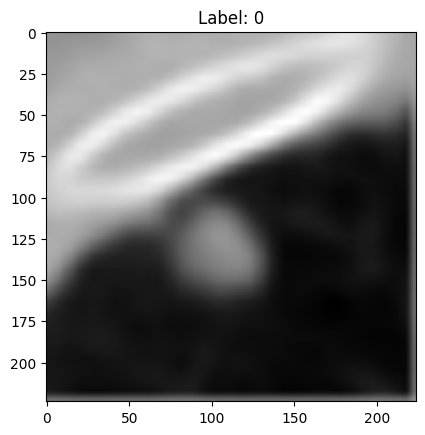

In [17]:
import matplotlib.pyplot as plt

idx = np.random.randint(0, len(x_train))
plt.imshow(x_train[idx], cmap='gray')
plt.title(f"Label: {y_train[idx]}")
plt.show()

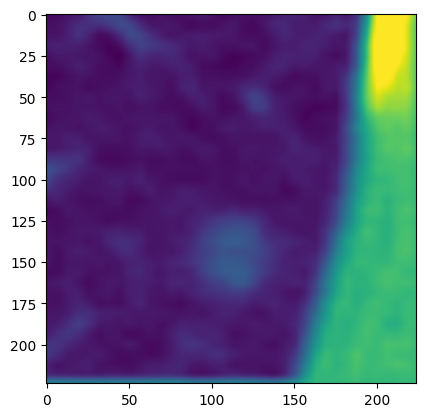

In [18]:
#Verify matching between image and label.
plt.imshow(x_train[100])


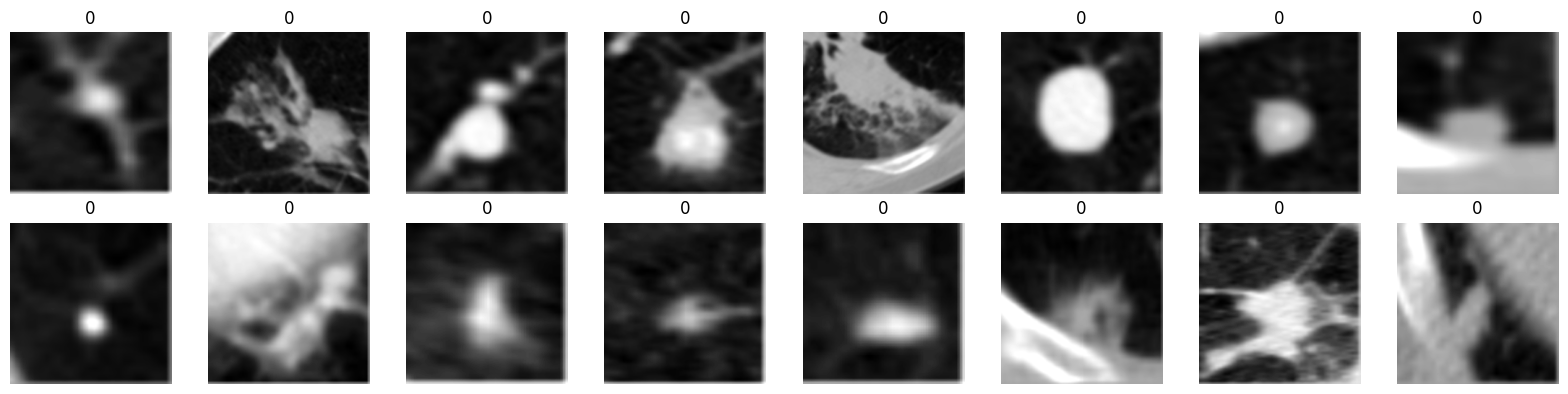

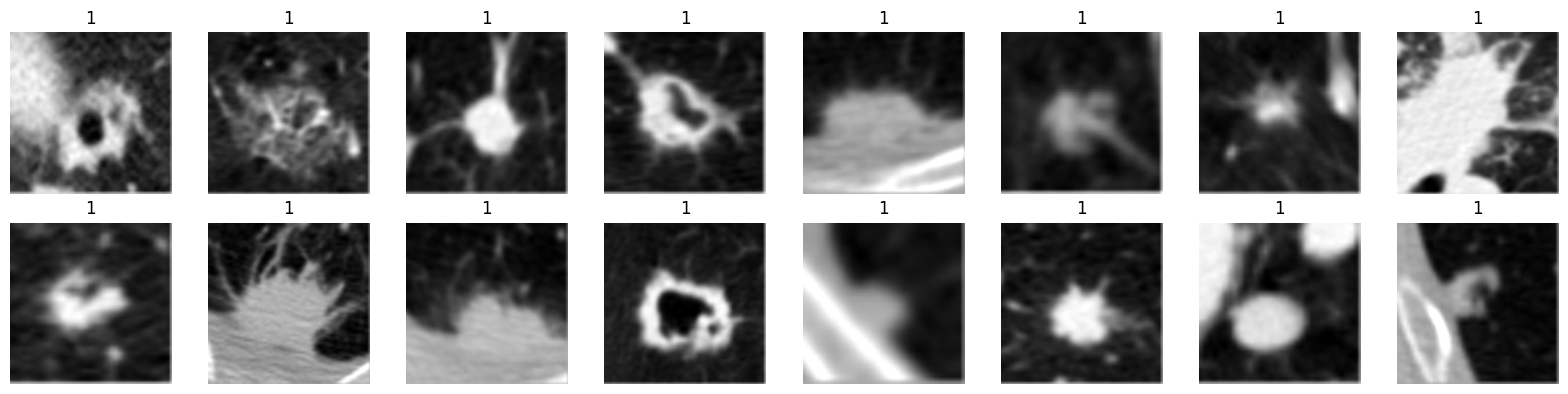

In [19]:
#For vizualisation purposes. Vizualizez a selection of images from the both classes and their corresponding labels

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 8, figsize=(16, 4))

# Array of titles
titles = y_train

# Iterate over each subplot and title
for i in range(2):
    for j in range(8):
        # Load and display the images
        axs[i, j].imshow(x_train[i*8 + j], cmap='gray')
        axs[i, j].set_title(titles[i*8 + j])
        axs[i, j].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

fig2, axs2 = plt.subplots(2, 8, figsize=(16, 4))

# Starting index
start_index = 890

# Repeat for second class
for k in range(2):
    for h in range(8):
        index = start_index + k*8 + h

        axs2[k, h].imshow(x_train[index], cmap='gray')

        axs2[k, h].set_title(y_train[index])

        axs2[k, h].axis('off')

plt.tight_layout()

plt.show()

# Balance datasets using Convolutional Generative Adversarial Network (DCGAN) 


In [100]:
# Training parameters
EPOCHS = 200
BATCH_SIZE = 6

Define GAN Architecture

In [109]:
from tensorflow.keras import layers, models
import tensorflow as tf

# Generator model for generating 224x224x1 images
def build_generator():
    model = models.Sequential()
    
    # Initial dense layer
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Reshape to (7, 7, 256)
    model.add(layers.Reshape((7, 7, 256)))
    
    # Upsample to (14, 14, 128)
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Upsample to (28, 28, 64)
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to (56, 56, 1)
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Upsample to (112, 112, 1)
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Upsample to (224, 224, 1)
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 224, 224, 1)
    
    return model
# Add BatchNormalization in Discriminator
def build_discriminator():
    model = tf.keras.Sequential()
    
    # Downsample to (112, 112, 1)
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(224, 224, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Downsample to (56, 56, 1)
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Downsample to (28, 28, 1)
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten and classify
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = build_discriminator()
generator = build_generator()
# Implement Learning Rate Scheduling
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

generator_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4, decay_steps=10000, decay_rate=0.9)
discriminator_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4, decay_steps=10000, decay_rate=0.9)

# Training loop
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return disc_loss



# Generate Images of Malignant Tumors



In [22]:
#Generate high resolution data of the malignant class.
malignant_hr_train, malignant_hr_test, skip, skip = get_train_test_arrays(c2_train_data_path, c2_test_data_path, c2_train_list, c2_val_list, 224, 224)


Reading: 0/293  of train images
Reading: 100/293  of train images
Reading: 200/293  of train images
Reading: 0/120  of train images
Reading: 100/120  of train images


In [23]:
# Load and preprocess dataset
malignant_data = np.concatenate((malignant_hr_train, malignant_hr_test))

dataset_mal = tf.data.Dataset.from_tensor_slices(malignant_data)

# Set batch size
batched_dataset_mal = dataset_mal.batch(BATCH_SIZE)

# list to store loss-values
discriminator_losses = []

Training-loop for the GAN 

In [111]:
import cv2
import numpy as np
import time

# Define the file path where you want to save the images
prog_im_file_path = "C:\\Users\\Johan\\Documents\\GY-Projekt\\TrainingProgression"
prog_gen_file_path = "C:\\Users\\Johan\\Documents\\GY-Projekt\\GeneratorProgression"


# Training loop for malignant testing data
for epoch in range(EPOCHS):
    start_time = time.time()  # Start the timer for the epoch
    print(f"Epoch {epoch}")
    
    for image_batch in batched_dataset_mal:
        disc_loss = train_step(image_batch)
        disc_loss_value = disc_loss.numpy()
        # Calculate and store discriminator loss
        discriminator_losses.append(disc_loss_value)

    end_time = time.time()  # End the timer for the epoch
    epoch_time = end_time - start_time  # Calculate the time for the epoch

    print(f"Epoch {epoch} took {epoch_time:.2f} seconds")

    if (epoch + 1) % 5 == 0:
        noise = tf.random.normal([1, 100])
        generated_image2 = generator(noise, training=False)
        generated_image2_array = (generated_image2[0].numpy() + 1) * 127.5  # Scale the image

        # Save the image using OpenCV
        cv2.imwrite(f"{prog_im_file_path}\\VERSION2generated_image_epoch_{epoch+1}.png", generated_image2_array)

        # Save the generator model
        generator.save(f"{prog_gen_file_path}\\VERSION2Advanced_generator_malignant_epoch_{epoch+1}.h5")



Epoch 0
Epoch 0 took 46.97 seconds
Epoch 1
Epoch 1 took 41.09 seconds
Epoch 2
Epoch 2 took 39.25 seconds
Epoch 3
Epoch 3 took 39.17 seconds
Epoch 4
Epoch 4 took 39.64 seconds
Epoch 5


c:\Users\Johan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 5 took 50.46 seconds
Epoch 6
Epoch 6 took 39.84 seconds
Epoch 7
Epoch 7 took 39.50 seconds
Epoch 8
Epoch 8 took 40.22 seconds
Epoch 9
Epoch 9 took 41.01 seconds
Epoch 10
Epoch 10 took 41.15 seconds
Epoch 11
Epoch 11 took 42.84 seconds
Epoch 12
Epoch 12 took 42.82 seconds
Epoch 13
Epoch 13 took 43.65 seconds
Epoch 14
Epoch 14 took 44.44 seconds
Epoch 15
Epoch 15 took 44.19 seconds
Epoch 16
Epoch 16 took 59.62 seconds
Epoch 17
Epoch 17 took 60.18 seconds
Epoch 18
Epoch 18 took 33.33 seconds
Epoch 19
Epoch 19 took 36.39 seconds
Epoch 20
Epoch 20 took 36.37 seconds
Epoch 21
Epoch 21 took 36.24 seconds
Epoch 22
Epoch 22 took 36.91 seconds
Epoch 23
Epoch 23 took 50.14 seconds
Epoch 24
Epoch 24 took 57.32 seconds
Epoch 25
Epoch 25 took 43.73 seconds
Epoch 26
Epoch 26 took 35.29 seconds
Epoch 27
Epoch 27 took 33.78 seconds
Epoch 28
Epoch 28 took 39.30 seconds
Epoch 29
Epoch 29 took 36.87 seconds
Epoch 30
Epoch 30 took 34.04 seconds
Epoch 31
Epoch 31 took 44.92 seconds
Epoch 32
Epoch 32 t

Visualise Discriminator Losses of the GAN-Network

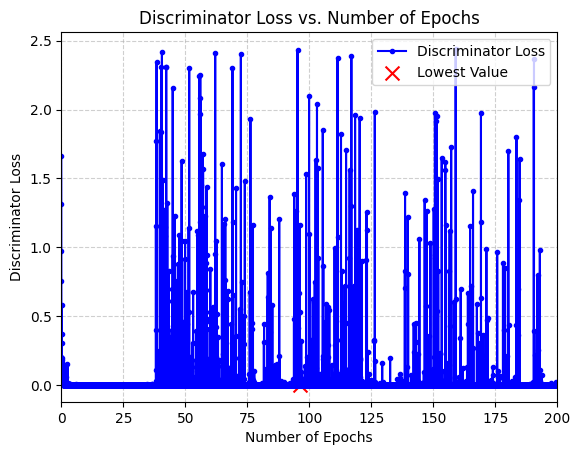

In [279]:
import matplotlib.pyplot as plt

nested_list = []
for i in range(0, len(discriminator_losses)):
    if discriminator_losses[i] <= 2.5:
        nested_list.append([i, discriminator_losses[i]])
data = nested_list

# Extract the first and second columns as separate lists
x_values = [item[0] for item in data]
y_values = [item[1] for item in data]

# Calculate the scaling factor to map the highest x-value to 200
scaling_factor = 200 / max(x_values)

# Scale the x-values
x_values_scaled = [x * scaling_factor for x in x_values]

# Find the index of the lowest value
min_y_index = y_values.index(min(y_values))
min_x = x_values_scaled[min_y_index]
min_y = y_values[min_y_index]

# Create a line plot with custom style and reduced marker size
plt.plot(x_values_scaled, y_values, marker='o', linestyle='-', color='b', label='Discriminator Loss', markersize=3)

# Annotate the lowest point with a larger 'x' marker that stands out
plt.scatter([min_x], [min_y], marker='x', color='red', s=100, label='Lowest Value')

# Add labels and a title
plt.xlabel("Number of Epochs")
plt.ylabel('Discriminator Loss')
plt.title('Discriminator Loss vs. Number of Epochs')

# Set the x-axis limits to be between 0 and 200
plt.xlim(0, 200)

# Add a grid
plt.grid(True, linestyle='--', alpha=0.6)

# Specify the full path, including the directory, to save the plot
output_path = r'C:\\Users\\Johan\\Documents\\GY-Projekt\\Fotografier\\GeneratorDiscriminatorLosses.png'

# Save the plot to the specified directory
plt.savefig(output_path, format='png', dpi = 300)

# Add a legend
plt.legend()

# Display the plot
plt.show()


Visualise Training Progression of the GAN Network


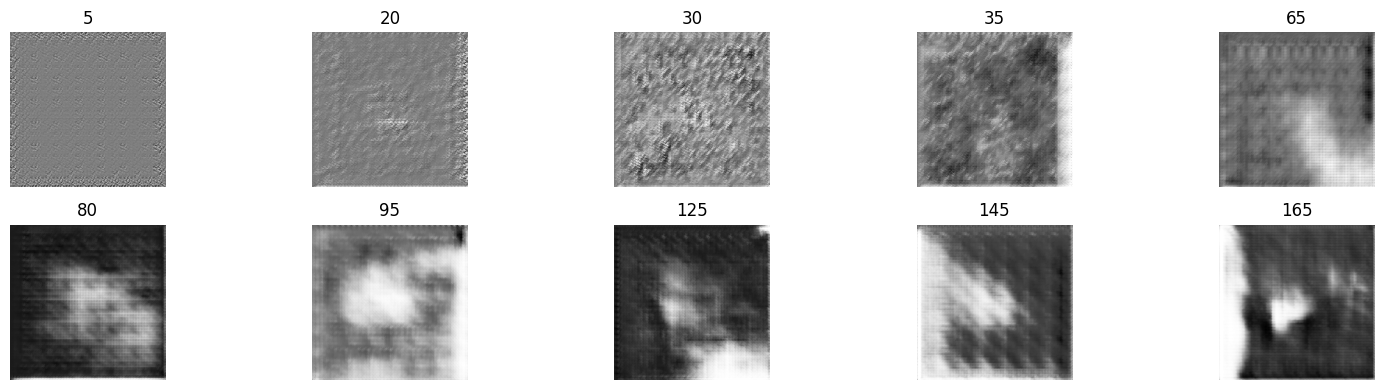

In [283]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Directory containing the images
image_dir = r'C:\Users\Johan\Documents\GY-Projekt\TrainingProgression\Display_in_report'

# List all image files in the directory
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

# Sort the image files based on the numeric part of the filename
image_files.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))

# Create a subplot with a 2x5 grid
fig, axs = plt.subplots(2, 5, figsize=(16, 4))

# Iterate over the sorted image files
for i in range(10):
    # Load and display the images
    image_path = os.path.join(image_dir, image_files[i])
    img = Image.open(image_path)
    # Remove the ".png" extension from the file name
    title = os.path.splitext(image_files[i])[0]
    axs[i // 5, i % 5].imshow(img, cmap='gray')
    axs[i // 5, i % 5].set_title(title)
    axs[i // 5, i % 5].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()
output_path = "C:\\Users\\Johan\\Documents\\GY-Projekt\\Fotografier\\GeneratorProgressionHighRes.png"
plt.savefig(output_path, bbox_inches='tight', pad_inches=0.1, format='png', dpi = 300)

plt.show()

# Create Balanced Training and Testing Data


In [113]:
# Save the generator model for later use
generator.save('C:\\Users\\Johan\\Documents\\GY-Projekt\\UPDATED_FINAL_GENERATOR.h5')

Synthetisize New Data


In [339]:
num_new_images = len(c1_x_train)-len(c2_x_train)
print(num_new_images)


455


Malignant Training Images



In [201]:
import os
import numpy as np
import tensorflow as tf 
from tensorflow import keras
# Get the current working directory
generator = keras.models.load_model('C:\\Users\\Johan\\Documents\\GY-Projekt\\GeneratorProgression\\VERSION2Advanced_generator_malignant_epoch_60.h5')

save_directory = "C:\\Users\\Johan\\Documents\\GY-Projekt\\GeneratedImages\\Malignant\\Generated_malignant"
num_images = num_new_images

for i in range(num_images): 
    # Generate a random noise vector
    noise = np.random.normal(0, 1, size=(1, 100))  # You can adjust the size as needed

    # Generate a new image using the generator
    generated_image_benign = generator.predict(noise)
    # Define the filename
    filename = 'Malignant_test_ep100_bs6_{nr}.png'.format(nr=str(i))

    # Create the full path by joining the current directory and the filename
    full_path = os.path.join(save_directory, filename)

    # Save the generated image using the full path
    tf.keras.preprocessing.image.save_img(full_path, generated_image_benign[0])


# Save the generated image
#tf.keras.preprocessing.image.save_img('generated_benign_image7.png', generated_image_benign[0])
#tf.keras.preprocessing.image.save_img('generated_malignant_image.png', generated_image_malignant[0])

1/1 [==============================] - 0s 55ms/step


Retrieve the Synthetizised Images


In [202]:
#Define input arguments for get_train_test_arrays (this line irrelevant)
c2_test_data_path_gen = "C:\\Users\\Johan\\Documents\\GY-Projekt\\GeneratedImages\\Malignant\\TestEp200Bs6"
#This is the path to the directory with the new 
c2_train_data_path_gen = "C:\\Users\\Johan\\Documents\\GY-Projekt\\GeneratedImages\\Malignant\\Generated_malignant"

c2_test_list_gen = os.listdir(c2_test_data_path_gen)
c2_train_list_gen = os.listdir(c2_train_data_path_gen)


#Retrieves training and testing data for C2 class (malignant)
#OBSERVE: The 
malignant_x_train, malignant_x_test, malignant_y_train, malignant_y_test = get_train_test_arrays(
        c2_train_data_path_gen, c2_test_data_path_gen,
        c2_train_list_gen, c2_test_list_gen, img_h, img_w)

Reading: 0/455  of train images
Reading: 100/455  of train images
Reading: 200/455  of train images
Reading: 300/455  of train images
Reading: 400/455  of train images
Reading: 0/134  of train images
Reading: 100/134  of train images


In [203]:
#The variables of interest are generated_malignant_x and malignant_labels, these are inserted to create the training data for the models further down. 
x_train = np.concatenate((c1_x_train, c2_x_train, malignant_x_train))
y_train = np.concatenate((c1_y_train, c2_y_train, malignant_y_train))
x_val = np.concatenate((c1_x_test, c2_x_test))
y_val = np.concatenate((c1_y_test, c2_y_test))

In [234]:
count_zeros = np.count_nonzero(y_train == 0)
count_ones = np.count_nonzero(y_train == 1)
print("Number of 0s in the training array:", count_zeros)
print("Number of 1s in the training array:", count_ones)
count_zeros = np.count_nonzero(y_val == 0)
count_ones = np.count_nonzero(y_val == 1)
print("Number of 0s in the testing array:", count_zeros)
print("Number of 1s in the testing array:", count_ones)

Number of 0s in the training array: 748
Number of 1s in the training array: 748
Number of 0s in the testing array: 120
Number of 1s in the testing array: 120


In [205]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[]


# Plotting Function

In [91]:
#Generates two subplots of learning curves
def plotting(model_name, directory_path, save, from_val, from_acc):

  model_std_loss = np.std(model_name.history["val_loss"][from_val:])
  model_mean_loss = np.mean(model_name.history["val_loss"][from_val:])
  model_boundary_high_loss = model_mean_loss + model_std_loss
  model_boundary_low_loss = model_mean_loss - model_std_loss

  model_std_acc = np.std(model_name.history["val_binary_accuracy"][from_acc:])
  model_mean_acc = np.mean(model_name.history["val_binary_accuracy"][from_acc:])
  model_boundary_high_acc = model_mean_acc + model_std_acc
  model_boundary_low_acc = model_mean_acc - model_std_acc

  fig, axes = plt.subplots(1, 2, figsize=(10, 4))

  # Plot Loss Value
  x_fill_loss = np.arange(from_val, len(model_name.history["val_loss"]))
  axes[1].fill_between(x_fill_loss, model_boundary_low_loss, model_boundary_high_loss, alpha=0.3, color='lightblue', label='$\pm 1 \sigma$')
  axes[1].plot(x_fill_loss, [model_mean_loss] * len(x_fill_loss), color='red', linestyle='--', label='mean val loss')
  axes[1].legend(frameon=False)

  axes[1].plot(model_name.history["loss"], label="train loss")
  axes[1].plot(model_name.history["val_loss"], label="val loss")
  axes[1].plot(np.argmin(model_name.history["val_loss"]),
              np.min(model_name.history["val_loss"]),
              marker="x", color="r", label="best model")
  axes[1].set_xlabel("Epochs")
  axes[1].set_ylabel("Loss Value")
  axes[1].legend(frameon=False)

  # Plot Validation Accuracy
  x_fill_loss = np.arange(from_acc, len(model_name.history["val_binary_accuracy"]))
  axes[0].fill_between(x_fill_loss, model_boundary_low_acc, model_boundary_high_acc, alpha=0.3, color='lightblue', label='$\pm 1 \sigma$')
  axes[0].plot(x_fill_loss, [model_mean_acc] * len(x_fill_loss), color='red', linestyle='--', label='mean val accuracy')
  axes[0].legend(frameon=False)

  axes[0].plot(model_name.history["binary_accuracy"], label="train accuracy")
  axes[0].plot(model_name.history["val_binary_accuracy"], label="val accuracy")
  axes[0].plot(np.argmax(model_name.history["val_binary_accuracy"]), np.max(model_name.history["val_binary_accuracy"]), marker="x", color="r", label="best model")
  axes[0].set_xlabel("Epochs")
  axes[0].set_ylabel("Accuracy")
  axes[0].legend(loc="lower right", frameon=False)

  plt.tight_layout()
  if save == True:
    plt.savefig(directory_path, dpi=300)

  plt.show()
  print(model_std_loss)
  print(model_std_acc)
  print(model_mean_loss)
  print(model_mean_acc)
  return

# Model Architectures

In [83]:
#LeNet Architecture
def LeNet(img_ch, img_width, img_height):
    model = Sequential()
    model.add(Conv2D(n_base, kernel_size = (3, 3), activation='relu',
                     strides=1, padding='same',
                     input_shape = (img_width, img_height, img_ch))) #base determines the number of filters that should be applied.
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(n_base*2, kernel_size = (3, 3), activation='relu',
                     strides=1, padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten()) #Flatten before entering the dense layer.
    model.add(Dense(n_base*2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    return model

In [221]:
# AlexNet Architecture
def AlexNet(img_ch, img_width, img_height):

    model = Sequential()

    model.add(Conv2D(filters=n_base, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=n_base*2, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=n_base*4, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=n_base*4, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=n_base*2, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.summary()
    return model

In [41]:
#VGG16 Architecture
def VGG_16(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))
    model.summary()
    return model

In [235]:
#Verify shapes
print(x_train.shape)
print(x_val.shape)

(1496, 224, 224, 1)
(240, 224, 224, 1)


In [236]:
#Define hyperparameters
img_ch, img_width, img_height = 1, 224, 224
####Parameters
n_epochs = 200
batch_s = 6
n_base = 4
####Parameters
learn_rate = 1e-5

In [237]:
#For the VGG16 & InceptionV3 models, the shape must be (244,244,3). The current shape is (244,244,1). The following code stacks three identical images on top of another to fulfill the criteria.
x_trainRGB = np.array([np.concatenate([gray_image] * 3, axis=2) for gray_image in x_train])
x_valRGB = np.array([np.concatenate([gray_image] * 3, axis=2) for gray_image in x_val])

# Pretrained VGG16 


In [213]:
#Instantiates the pre-trained VGG16 network
VGG16 = applications.VGG16(include_top=False, weights='imagenet')

#Makes sure the model won't be trained
for layer in VGG16.layers:
    layer.trainable = False

In [214]:
#Generates feature maps from the VGG16 model
x_train_predict = VGG16.predict(x_trainRGB)
x_val_predict = VGG16.predict(x_valRGB)

8/8 [==============================] - 52s 6s/step


In [215]:
#Defines the trainable neural network connected to the pre-trained VGG16 model
model_1 = Sequential()
model_1.add(Flatten(input_shape=x_train_predict.shape[1:]))
model_1.add(Dense(512, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(256, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(32, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(1, activation='sigmoid'))
model_1.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 25088)             0         
                                                                 
 dense_32 (Dense)            (None, 512)               12845568  
                                                                 
 dropout_30 (Dropout)        (None, 512)               0         
                                                                 
 dense_33 (Dense)            (None, 256)               131328    
                                                                 
 dropout_31 (Dropout)        (None, 256)               0         
                                                                 
 dense_34 (Dense)            (None, 32)                8224      
                                                                 
 dropout_32 (Dropout)        (None, 32)              

In [216]:
model_1.compile(optimizer=Adam(learning_rate = learn_rate),loss='binary_crossentropy', metrics=['accuracy'])

In [217]:
#Fit the neural network added on top of the VGG16 model
VGG16 = model_1.fit(x_train_predict, y_train,
          epochs=n_epochs,
          batch_size=batch_s,
          validation_data=(x_val_predict, y_val))

Epoch 1/200
250/250 [==============================] - 38s 149ms/step - loss: 0.7259 - accuracy: 0.5648 - val_loss: 0.7067 - val_accuracy: 0.4958
Epoch 2/200
250/250 [==============================] - 38s 150ms/step - loss: 0.6322 - accuracy: 0.6551 - val_loss: 0.7432 - val_accuracy: 0.5042
Epoch 3/200
250/250 [==============================] - 37s 146ms/step - loss: 0.5347 - accuracy: 0.7346 - val_loss: 0.7117 - val_accuracy: 0.5250
Epoch 4/200
250/250 [==============================] - 37s 146ms/step - loss: 0.5049 - accuracy: 0.7480 - val_loss: 0.7613 - val_accuracy: 0.5125
Epoch 5/200
250/250 [==============================] - 37s 149ms/step - loss: 0.4784 - accuracy: 0.7714 - val_loss: 0.7069 - val_accuracy: 0.5458
Epoch 6/200
250/250 [==============================] - 38s 152ms/step - loss: 0.4648 - accuracy: 0.7794 - val_loss: 0.6777 - val_accuracy: 0.5708
Epoch 7/200
250/250 [==============================] - 38s 152ms/step - loss: 0.4608 - accuracy: 0.7721 - val_loss: 0.6984 -

In [218]:
model_file_path = "C:\\Users\\Johan\\Documents\\Modeller\\VGG16_pretr_ep200_imbs6_extended_trainingset.h5"

# Save the model
model_1.save(model_file_path)

c:\Users\Johan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [58]:
history_file_path = "C:\\Users\\Johan\\Documents\\Modeller\\VGG16_pretr_ep200_imbs6_HISTORY.h5"

with open(history_file_path, "wb") as file:
    pickle.dump(VGG16.history, file)

In [285]:
#statistics.
VGG16_std_loss = np.std(VGG16.history["val_loss"][25:])
VGG16_mean_loss = np.mean(VGG16.history["val_loss"][25:])
VGG16_boundary_high_loss = VGG16_mean_loss + VGG16_std_loss
VGG16_boundary_low_loss = VGG16_mean_loss - VGG16_std_loss

VGG16_std_acc = np.std(VGG16.history["val_accuracy"][25:])
VGG16_mean_acc = np.mean(VGG16.history["val_accuracy"][25:])
VGG16_boundary_high_acc = VGG16_mean_acc + VGG16_std_acc
VGG16_boundary_low_acc = VGG16_mean_acc - VGG16_std_acc

print(VGG16_std_loss)
print(VGG16_std_acc)
print(VGG16_mean_loss)
print(VGG16_mean_acc)

0.391920377204388
0.018172606315097165
1.084074546609606
0.6376190447807312


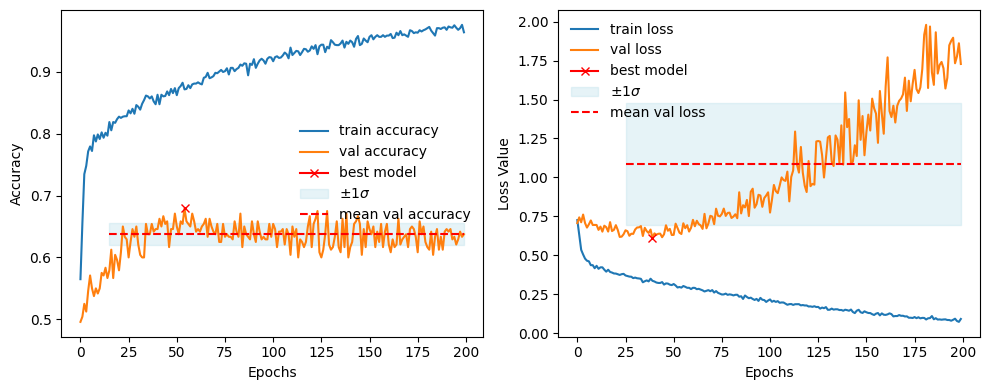

In [287]:
#Plot the learning curves of the VGG16 model
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot for Loss Value

# Plotting
axes[1].plot(VGG16.history["loss"], label="train loss")
axes[1].plot(VGG16.history["val_loss"], label="val loss")
axes[1].plot(np.argmin(VGG16.history["val_loss"]),
             np.min(VGG16.history["val_loss"]),
             marker="x", color="r", label="best model")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss Value")

# Fill between decision boundaries
x_fill_loss = np.arange(25, len(VGG16.history["val_loss"]))
axes[1].fill_between(x_fill_loss, VGG16_boundary_low_loss, VGG16_boundary_high_loss, alpha=0.3, color='lightblue', label='$\pm 1 \sigma$')
axes[1].plot(x_fill_loss, [VGG16_mean_loss] * len(x_fill_loss), color='red', linestyle='--', label='mean val loss')
axes[1].legend(frameon=False)


# Plot for Validation Accuracy
axes[0].plot(VGG16.history["accuracy"], label="train accuracy")
axes[0].plot(VGG16.history["val_accuracy"], label="val accuracy")
axes[0].plot(np.argmax(VGG16.history["val_accuracy"]),
             np.max(VGG16.history["val_accuracy"]),
             marker="x", color="r", label="best model")

x_fill_acc = np.arange(15, len(VGG16.history["val_accuracy"]))
axes[0].fill_between(x_fill_acc, VGG16_boundary_low_acc, VGG16_boundary_high_acc, alpha=0.3, color='lightblue', label='$\pm 1 \sigma$')
axes[0].plot(x_fill_acc, [VGG16_mean_acc] * len(x_fill_acc), color='red', linestyle='--', label='mean val accuracy')

axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].legend(frameon=False)

plt.tight_layout()


plt.savefig("C:\\Users\\Johan\\Documents\\GY-Projekt\\Fotografier\\VGG16Benchmarks.png", dpi=300)

plt.show()
print()

# Inceptionnet

In [238]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load the pretrained InceptionNet model without the top layer
base_model = InceptionV3(weights='imagenet', include_top=False)


In [239]:
#Generates feature maps from the InceptionV3 model
x_train_predict = base_model.predict(x_trainRGB)
x_val_predict = base_model.predict(x_valRGB)

8/8 [==============================] - 14s 2s/step


In [240]:
#Create simple CNN architecture to add on top of InceptionV3
from tensorflow.keras.models import Sequential 
model = Sequential()
model.add(Flatten(input_shape=x_train_predict.shape[1:]))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_13 (Flatten)        (None, 51200)             0         
                                                                 
 dense_43 (Dense)            (None, 512)               26214912  
                                                                 
 dropout_38 (Dropout)        (None, 512)               0         
                                                                 
 dense_44 (Dense)            (None, 256)               131328    
                                                                 
 dropout_39 (Dropout)        (None, 256)               0         
                                                                 
 dense_45 (Dense)            (None, 32)                8224      
                                                                 
 dropout_40 (Dropout)        (None, 32)              

In [241]:
model.compile(optimizer=Adam(learning_rate = learn_rate),loss='binary_crossentropy', metrics=['accuracy'])

In [242]:
#Fit the neural network added on top of the VGG16 model
InceptionV3 = model.fit(x_train_predict, y_train,
          epochs=n_epochs,
          batch_size=batch_s,
          validation_data=(x_val_predict, y_val))

Epoch 1/200
250/250 [==============================] - 76s 298ms/step - loss: 0.7052 - accuracy: 0.7045 - val_loss: 0.7547 - val_accuracy: 0.5292
Epoch 2/200
250/250 [==============================] - 65s 262ms/step - loss: 0.5346 - accuracy: 0.7567 - val_loss: 0.6666 - val_accuracy: 0.5708
Epoch 3/200
250/250 [==============================] - 65s 258ms/step - loss: 0.4855 - accuracy: 0.7640 - val_loss: 0.6622 - val_accuracy: 0.6000
Epoch 4/200
250/250 [==============================] - 61s 245ms/step - loss: 0.4932 - accuracy: 0.7587 - val_loss: 0.6555 - val_accuracy: 0.6000
Epoch 5/200
250/250 [==============================] - 61s 246ms/step - loss: 0.4439 - accuracy: 0.7901 - val_loss: 0.6300 - val_accuracy: 0.6208
Epoch 6/200
250/250 [==============================] - 61s 245ms/step - loss: 0.3875 - accuracy: 0.8195 - val_loss: 0.6516 - val_accuracy: 0.6583
Epoch 7/200
250/250 [==============================] - 62s 248ms/step - loss: 0.3956 - accuracy: 0.8155 - val_loss: 0.6928 -

In [243]:
model_file_path = "C:\\Users\\Johan\\Documents\\Modeller\\INCEPTIONNET_pretr_ep50_imbs6_imep200.h5"

# Save the model
model.save(model_file_path)

history_file_path = "C:\\Users\\Johan\\Documents\\Modeller\\INCEPTIONNET_pretr_ep50_imbs6_imep200_HISTORY.h5"

with open(history_file_path, "wb") as file:
    pickle.dump(InceptionV3.history, file)

c:\Users\Johan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [288]:
#statistics (should be InceptionetV3, not VGG16).
VGG16_std_loss = np.std(InceptionV3.history["val_loss"][25:])
VGG16_mean_loss = np.mean(InceptionV3.history["val_loss"][25:])
VGG16_boundary_high_loss = VGG16_mean_loss + VGG16_std_loss
VGG16_boundary_low_loss = VGG16_mean_loss - VGG16_std_loss

VGG16_std_acc = np.std(InceptionV3.history["val_accuracy"][25:])
VGG16_mean_acc = np.mean(InceptionV3.history["val_accuracy"][25:])
VGG16_boundary_high_acc = VGG16_mean_acc + VGG16_std_acc
VGG16_boundary_low_acc = VGG16_mean_acc - VGG16_std_acc

print(VGG16_std_loss)
print(VGG16_std_acc)
print(VGG16_mean_loss)
print(VGG16_mean_acc)

1.378950309634625
0.02236962505814837
3.7904872281210764
0.6139761928149632


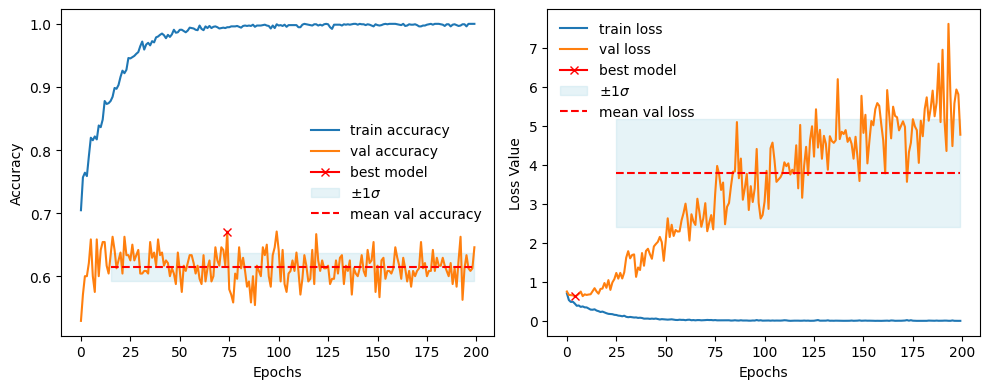

In [289]:
#Plot the learning curves from the InceptionV3 model
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plotting
axes[1].plot(InceptionV3.history["loss"], label="train loss")
axes[1].plot(InceptionV3.history["val_loss"], label="val loss")
axes[1].plot(np.argmin(InceptionV3.history["val_loss"]),
             np.min(InceptionV3.history["val_loss"]),
             marker="x", color="r", label="best model")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss Value")

# Fill between decision boundaries
x_fill_loss = np.arange(25, len(InceptionV3.history["val_loss"]))
axes[1].fill_between(x_fill_loss, VGG16_boundary_low_loss, VGG16_boundary_high_loss, alpha=0.3, color='lightblue', label='$\pm 1 \sigma$')
axes[1].plot(x_fill_loss, [VGG16_mean_loss] * len(x_fill_loss), color='red', linestyle='--', label='mean val loss')
axes[1].legend(frameon=False)


# Plot for Validation Accuracy
axes[0].plot(InceptionV3.history["accuracy"], label="train accuracy")
axes[0].plot(InceptionV3.history["val_accuracy"], label="val accuracy")
axes[0].plot(np.argmax(InceptionV3.history["val_accuracy"]),
             np.max(InceptionV3.history["val_accuracy"]),
             marker="x", color="r", label="best model")

x_fill_acc = np.arange(15, len(InceptionV3.history["val_accuracy"]))
axes[0].fill_between(x_fill_acc, VGG16_boundary_low_acc, VGG16_boundary_high_acc, alpha=0.3, color='lightblue', label='$\pm 1 \sigma$')
axes[0].plot(x_fill_acc, [VGG16_mean_acc] * len(x_fill_acc), color='red', linestyle='--', label='mean val accuracy')

axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].legend(frameon=False)

plt.tight_layout()

plt.savefig("C:\\Users\\Johan\\Documents\\GY-Projekt\\Fotografier\\InceptionV3_ep50_not_complete", dpi=300)

plt.show()
print()

In [293]:
InceptionV3.history["val_accuracy"]

[0.5291666388511658,
 0.5708333253860474,
 0.6000000238418579,
 0.6000000238418579,
 0.6208333373069763,
 0.6583333611488342,
 0.6000000238418579,
 0.574999988079071,
 0.6583333611488342,
 0.6000000238418579,
 0.6416666507720947,
 0.6541666388511658,
 0.6541666388511658,
 0.6166666746139526,
 0.6041666865348816,
 0.6333333253860474,
 0.6625000238418579,
 0.6416666507720947,
 0.612500011920929,
 0.625,
 0.637499988079071,
 0.6041666865348816,
 0.6625000238418579,
 0.6333333253860474,
 0.6333333253860474,
 0.625,
 0.6499999761581421,
 0.625,
 0.6333333253860474,
 0.6416666507720947,
 0.6041666865348816,
 0.6041666865348816,
 0.6083333492279053,
 0.6083333492279053,
 0.6041666865348816,
 0.6541666388511658,
 0.6291666626930237,
 0.637499988079071,
 0.6166666746139526,
 0.6583333611488342,
 0.6333333253860474,
 0.637499988079071,
 0.6166666746139526,
 0.625,
 0.6208333373069763,
 0.6000000238418579,
 0.612500011920929,
 0.6041666865348816,
 0.5874999761581421,
 0.637499988079071,
 0.608333

# AlexNet (Not Used in Updated Report)

In [222]:
#Define HyperParameters for AlexNet and LeNet
img_ch, img_width, img_height = 1, 224, 224
n_epochs = 200
batch_s = 3
n_base = 4
learn_rate = 1e-5

In [224]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

alex = AlexNet(img_ch, img_width, img_height)

alex.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=learn_rate),
              metrics=['binary_accuracy'])

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_200 (Conv2D)         (None, 224, 224, 4)       40        
                                                                 
 activation_188 (Activation  (None, 224, 224, 4)       0         
 )                                                               
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 112, 112, 4)       0         
 g2D)                                                            
                                                                 
 conv2d_201 (Conv2D)         (None, 112, 112, 8)       296       
                                                                 
 activation_189 (Activation  (None, 112, 112, 8)       0         
 )                                                               
                                                     

In [ ]:
#Train the AlexNet model
alex_hist = alex.fit(x_train, y_train, batch_size = batch_s,
                  validation_data = (x_val, y_val),
                  epochs = n_epochs, verbose=1)

In [90]:
model_file_path = '/content/drive/My Drive/Rays/Projects/Saved_Models/AlexNet.h5'

# Save the model
alex.save(model_file_path)

history_file_path = '/content/drive/My Drive/Rays/Projects/Saved_Models/Saved_hist/AlexNet_hist.pickle'

with open(history_file_path, "wb") as file:
    pickle.dump(alex_hist.history, file)

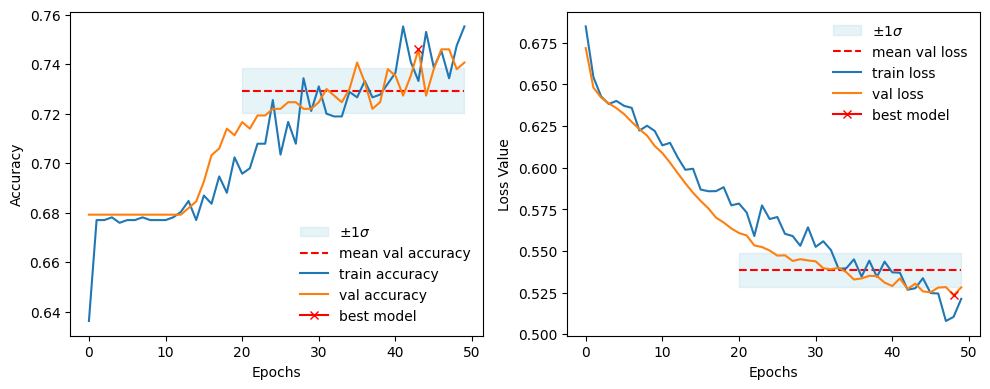

0.010183349229041731
0.008939799591165462
0.5382720212141673
0.7293226440747579


In [79]:
#Plot the AlexNet learning curves

plotting(alex_hist, "/content/drive/My Drive/Rays/Images_Graphs/Statistical/AlexNET_50epochs_stats_Transparent.png", True, 20, 20)

# LeNet (Not Used in Updated Report)

In [42]:
#Instantiate the LeNet Model
lenet = LeNet(img_ch, img_width, img_height)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 224, 224, 4)       40        
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 4)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 8)       296       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 8)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_7 (Dense)             (None, 8)                

In [43]:
lenet.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=learn_rate),
              metrics=['binary_accuracy'])

In [44]:
#Train the LeNet model
lenet_hist = lenet.fit(x_train, y_train, batch_size = batch_s,
                  validation_data = (x_val, y_val),
                  epochs = n_epochs, verbose=1)

Epoch 1/50
303/303 [==============================] - 28s 90ms/step - loss: 0.6903 - binary_accuracy: 0.6163 - val_loss: 0.6833 - val_binary_accuracy: 0.6791
Epoch 2/50
303/303 [==============================] - 27s 89ms/step - loss: 0.6663 - binary_accuracy: 0.6770 - val_loss: 0.6513 - val_binary_accuracy: 0.6791
Epoch 3/50
303/303 [==============================] - 29s 96ms/step - loss: 0.6402 - binary_accuracy: 0.6770 - val_loss: 0.6344 - val_binary_accuracy: 0.6791
Epoch 4/50
303/303 [==============================] - 27s 88ms/step - loss: 0.6304 - binary_accuracy: 0.6770 - val_loss: 0.6289 - val_binary_accuracy: 0.6791
Epoch 5/50
303/303 [==============================] - 25s 83ms/step - loss: 0.6266 - binary_accuracy: 0.6770 - val_loss: 0.6252 - val_binary_accuracy: 0.6791
Epoch 6/50
303/303 [==============================] - 27s 89ms/step - loss: 0.6229 - binary_accuracy: 0.6770 - val_loss: 0.6223 - val_binary_accuracy: 0.6791
Epoch 7/50
303/303 [==============================] 

In [88]:
model_file_path = '/content/drive/My Drive/Rays/Projects/Saved_Models/LeNet.h5'

# Save the model

lenet.save(model_file_path)

history_file_path = '/content/drive/My Drive/Rays/Projects/Saved_Models/Saved_hist/LeNet_hist.pickle'

with open(history_file_path, "wb") as file:
    pickle.dump(lenet_hist.history, file)

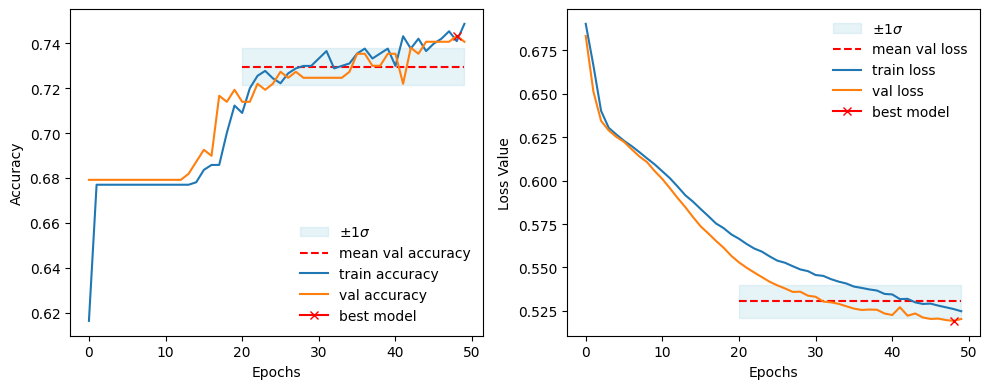

0.00942226352289513
0.008160799357512686
0.5304199854532877
0.7295900225639343


In [85]:
#Plot the LeNet learning curves
plotting(lenet_hist, "/content/drive/My Drive/Rays/Images_Graphs/Statistical/LeNET_50epochs_stats_Transparent.png", True, 20,20)

# Summarize Benchmarks of the different models by Creating a Violin Plot

Open Stored validation accuracies from the Random Forest Model

In [303]:
file_path = "C:\\Users\\Johan\\Documents\\GY-Projekt\\data\\Optimized_with_Balanced_dictionary.pkl"

# Load the dictionary from the pickle file
with open(file_path, 'rb') as pickle_file:
    rf_auc_estimators_val = pickle.load(pickle_file)

RFValAccuracy = list(rf_auc_estimators_val.keys())

Visualise validation accuracies via a Violin Plot

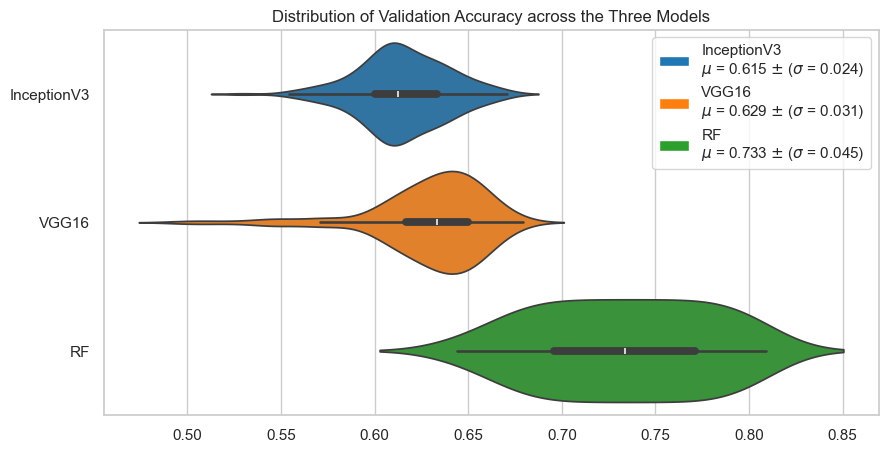

In [340]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

data1 = InceptionV3.history["val_accuracy"]
data2 = VGG16.history["val_accuracy"]
data3 = RFValAccuracy

# Combine the data into a single list
combined_data = [data1, data2, data3]


custom_colors = ["#1f77b4", "#ff7f0e", "#2ca02c"] 
custom_labels = ["InceptionV3", "VGG16", "Random Forest"] 
custom_labels2 = ["InceptionV3", "VGG16", "RF"]

std_dev_data1 = round(np.std(data1), ndigits=3)
mean_data1 = round(np.mean(data1), ndigits=3)

std_dev_data2 = round(np.std(data2), ndigits=3)
mean_data2 = round(np.mean(data2), ndigits=3)

std_dev_data3 = round(np.std(data3), ndigits=3)
mean_data3 = round(np.mean(data3), ndigits=3)


legend_labels = [f"{label}\n$\mu$ = {mean} $\pm$ ($\sigma$ = {std_dev})" for label, mean, std_dev in zip(custom_labels2, [mean_data1, mean_data2, mean_data3], [std_dev_data1, std_dev_data2, std_dev_data3])]

# Create a horizontal violin plot 
plt.figure(figsize=(10, 5))
sns.violinplot(data=combined_data, palette=custom_colors, orient="h")


plt.title("Distribution of Validation Accuracy across the Three Models")

# Set y-labels to custom model names
plt.yticks(range(len(custom_labels2)), custom_labels2)

# Customize the legend
legend_handles = [plt.Rectangle((0, 0), 1, 1, fc=color) for color in custom_colors]
plt.legend(legend_handles, legend_labels, loc="upper right")
plt.savefig("C:\\Users\\Johan\\Documents\\GY-Projekt\\Fotografier\\ViolinPlot.png", dpi=300)


plt.show()
